In [1]:
import os
import rootpath
import sys
sys.path.append(rootpath.detect())

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

from testsuite.results import ResultsContainer
from testsuite.utilities import str_format, single_target_dominated_hypervolume
from testsuite.analysis_tools import strip_problem_names, get_factors
import wfg
from collections import defaultdict

In [2]:
# establish location to save tables
output_table_dir = os.path.join(rootpath.detect(), 'experiments/directed/results/tables/')
assert os.path.isdir(output_table_dir)

In [3]:
# establish location from which to load data
RESULTS_DIR = os.path.join(rootpath.detect(), 'experiments/directed/data/')
TEST_FUNCTIONS = sorted(os.listdir(RESULTS_DIR))
FUNCTION_DIRS = [os.path.join(RESULTS_DIR, tc, 'log_data/') for tc in TEST_FUNCTIONS]

In [4]:
TEST_FUNCTIONS

['wfg1_2obj_3dim',
 'wfg1_3obj_4dim',
 'wfg1_4obj_5dim',
 'wfg2_2obj_6dim',
 'wfg2_3obj_6dim',
 'wfg2_4obj_10dim',
 'wfg3_2obj_6dim',
 'wfg3_3obj_10dim',
 'wfg3_4obj_10dim',
 'wfg4_2obj_6dim',
 'wfg4_3obj_8dim',
 'wfg4_4obj_8dim',
 'wfg5_2obj_6dim',
 'wfg5_3obj_8dim',
 'wfg5_4obj_10dim',
 'wfg6_2obj_6dim',
 'wfg6_3obj_8dim',
 'wfg6_4obj_10dim']

In [5]:
# generate dictionary of problem targets 
targets_path = os.path.join(rootpath.detect(), 'experiments/directed/template/targets/targets')
with open(targets_path, "r") as infile:
    targets_old = json.load(infile)
targets_old = {k.lower(): np.asarray(v) for k, v in targets_old.items()}

TARGETS_DICT = {}
for function in TEST_FUNCTIONS:
    try:
        # corrrects ordering mistake in function target orders
        TARGETS_DICT[function] = np.vstack((targets_old[function][:3][np.argsort(targets_old[function][:3, 0])],targets_old[function][3:][np.argsort(targets_old[function][3:, 0])]))
    except KeyError:
        n_obj = int(function.split("_")[1].strip("obj"))
        TARGETS_DICT[function] = np.vstack((targets_old[f"ellipsoid_{n_obj}obj"][:3][np.argsort(targets_old[f"ellipsoid_{n_obj}obj"][:3, 0])],targets_old[f"ellipsoid_{n_obj}obj"][3:][np.argsort(targets_old[f"ellipsoid_{n_obj}obj"][3:, 0])]))
        

del(targets_old)

In [6]:
TARGETS_DICT

{'wfg1_2obj_3dim': array([[0.354, 3.139],
        [0.393, 3.487],
        [0.433, 3.836],
        [1.508, 0.979],
        [1.675, 1.088],
        [1.843, 1.197]]),
 'wfg1_3obj_4dim': array([[0.332, 1.352, 1.308],
        [0.369, 1.502, 1.453],
        [0.406, 1.652, 1.599],
        [0.805, 0.31 , 1.894],
        [0.895, 0.345, 2.104],
        [0.984, 0.379, 2.314]]),
 'wfg1_4obj_5dim': array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142],
        [0.00563116, 0.01611537, 2.30456478, 2.96855713],
        [0.00619428, 0.01772691, 2.53502125, 3.26541285],
        [0.2840733 , 0.33494929, 0.59489375, 0.77715356],
        [0.315637  , 0.37216588, 0.66099306, 0.86350396],
        [0.3472007 , 0.40938246, 0.72709236, 0.94985435]]),
 'wfg2_2obj_6dim': array([[0.302, 2.46 ],
        [0.336, 2.734],
        [0.369, 3.007],
        [1.181, 1.179],
        [1.312, 1.309],
        [1.443, 1.44 ]]),
 'wfg2_3obj_6dim': array([[1.042, 0.293, 0.731],
        [1.158, 0.325, 0.812],
        [1.274, 0.

In [7]:
# split targets dict into 3
D_unattainable = {k: [np.asarray(v[i]) for i in [0, 3]] for k, v in TARGETS_DICT.items()}
D_pareto = {k: [np.asarray(v[i]) for i in [1, 4]] for k, v in TARGETS_DICT.items()}
D_attainable = {k: [np.asarray(v[i]) for i in [2, 5]] for k, v in TARGETS_DICT.items()}

In [8]:
D_unattainable

{'wfg1_2obj_3dim': [array([0.354, 3.139]), array([1.508, 0.979])],
 'wfg1_3obj_4dim': [array([0.332, 1.352, 1.308]),
  array([0.805, 0.31 , 1.894])],
 'wfg1_4obj_5dim': [array([0.00506805, 0.01450383, 2.0741083 , 2.67170142]),
  array([0.2840733 , 0.33494929, 0.59489375, 0.77715356])],
 'wfg2_2obj_6dim': [array([0.302, 2.46 ]), array([1.181, 1.179])],
 'wfg2_3obj_6dim': [array([1.042, 0.293, 0.731]),
  array([0.085, 1.48 , 1.852])],
 'wfg2_4obj_10dim': [array([0.05333501, 2.33966739, 0.02223603, 1.23056658]),
  array([2.41193562e-01, 5.34313815e-09, 1.34895443e-02, 5.87938870e+00])],
 'wfg3_2obj_6dim': [array([0.36, 2.88]), array([1.261, 1.079])],
 'wfg3_3obj_10dim': [array([0.18 , 0.36 , 4.319]),
  array([0.63 , 1.261, 1.618])],
 'wfg3_4obj_10dim': [array([0.12602521, 0.25205041, 0.75615123, 5.18359672]),
  array([0.39607922, 0.79215843, 2.3764753 , 0.86273255])],
 'wfg4_2obj_6dim': [array([1.714, 1.102]), array([0.8865, 3.132 ])],
 'wfg4_3obj_8dim': [array([0.459, 3.303, 1.647]),
  a

In [9]:
D_pareto

{'wfg1_2obj_3dim': [array([0.393, 3.487]), array([1.675, 1.088])],
 'wfg1_3obj_4dim': [array([0.369, 1.502, 1.453]),
  array([0.895, 0.345, 2.104])],
 'wfg1_4obj_5dim': [array([0.00563116, 0.01611537, 2.30456478, 2.96855713]),
  array([0.315637  , 0.37216588, 0.66099306, 0.86350396])],
 'wfg2_2obj_6dim': [array([0.336, 2.734]), array([1.312, 1.309])],
 'wfg2_3obj_6dim': [array([1.158, 0.325, 0.812]),
  array([0.094, 1.644, 2.058])],
 'wfg2_4obj_10dim': [array([0.05926112, 2.59963043, 0.0247067 , 1.3672962 ]),
  array([2.67992847e-01, 5.93682017e-09, 1.49883826e-02, 6.53265411e+00])],
 'wfg3_2obj_6dim': [array([0.4, 3.2]), array([1.401, 1.199])],
 'wfg3_3obj_10dim': [array([0.2  , 0.4  , 4.799]),
  array([0.7  , 1.401, 1.798])],
 'wfg3_4obj_10dim': [array([0.14002801, 0.28005601, 0.84016803, 5.75955191]),
  array([0.44008802, 0.88017604, 2.64052811, 0.95859172])],
 'wfg4_2obj_6dim': [array([1.904, 1.225]), array([0.985, 3.48 ])],
 'wfg4_3obj_8dim': [array([0.51, 3.67, 1.83]), array([1.7

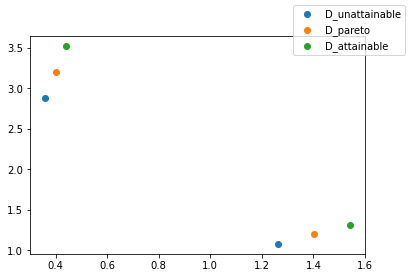

In [10]:
prob = 'wfg3_2obj_6dim'
Ds = [D_unattainable, D_pareto, D_attainable]
names = ['D_unattainable', 'D_pareto', 'D_attainable']

fig = plt.figure()
ax = fig.gca()
for i, D in enumerate(Ds):
    ax.scatter(*np.asarray(D[prob]).T, c=f"C{i}", label=names[i])
fig.legend()

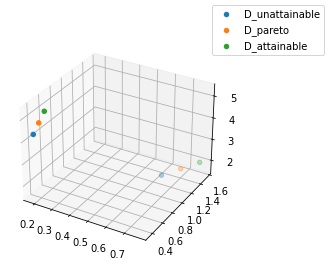

In [11]:
prob = 'wfg3_3obj_10dim'
Ds = [D_unattainable, D_pareto, D_attainable]
names = ['D_unattainable', 'D_pareto', 'D_attainable']

fig = plt.figure()
ax = fig.gca(projection="3d")
for i, D in enumerate(Ds):
    ax.scatter(*np.asarray(D[prob]).T, c=f"C{i}", label=names[i])
fig.legend()

In [36]:
# write function to load data based on dict.
def target_to_Result(results_dir, prob_name, t):
    """
    takes in a directory for results, the name of the problem and the target value,
    returns the ResultsContainer for all repeats from this experiment
    """
    ## check supplied data
    assert os.path.isdir(results_dir)
    assert prob_name in TEST_FUNCTIONS 
    assert prob_name in TARGETS_DICT.keys() 
    
    target_string = str(np.round(t, 2)).replace(".", "p").replace(" ", "_").replace("[","").replace("]", "")
    print(type(target_string))
    print(target_string)
    problem_files = [i for i in os.listdir(results_dir)
                     if i[:len(prob_name)] == prob_name]
#     target_files = [i for i in processed_files]
    
    for pf in os.listdir(results_dir):
        if (target_string in pf) and (prob_name in pf):
            return ResultsContainer(os.path.join(results_dir, pf))
        

name = 'wfg1_4obj_5dim'
processed_results_dir = "../processed_results" 
results = target_to_Result(results_dir=processed_results_dir, prob_name=name, t=TARGETS_DICT[name][0])
results

<class 'str'>
0p01_0p01_2p07_2p67


In [37]:
for k, i in D_pareto.items():
    print(k)

wfg1_2obj_3dim
wfg1_3obj_4dim
wfg1_4obj_5dim
wfg2_2obj_6dim
wfg2_3obj_6dim
wfg2_4obj_10dim
wfg3_2obj_6dim
wfg3_3obj_10dim
wfg3_4obj_10dim
wfg4_2obj_6dim
wfg4_3obj_8dim
wfg4_4obj_8dim
wfg5_2obj_6dim
wfg5_3obj_8dim
wfg5_4obj_10dim
wfg6_2obj_6dim
wfg6_3obj_8dim
wfg6_4obj_10dim


In [21]:
results_dir

'/home/finley/phd/code/testsuite/experiments/directed/data/'

In [18]:
results_unattainable = {name: [target_to_Result(results_dir, name, t[0]), target_to_Result(results_dir, name, t[1])] for name, t in D_unattainable.items()}
# results_pareto = {name: [target_to_Result(results_dir, name, t[0]), target_to_Result(results_dir, name, t[1])] for name, t in D_pareto.items()}
# results_attainable = {name: [target_to_Result(results_dir, name, t[0]), target_to_Result(results_dir, name, t[1])] for name, t in D_attainable.items()}

IndexError: list index out of range

In [15]:
for k, v in results_unattainable.items():
    n_obj = v[0].n_obj[0]
    print(k, "\t", n_obj)
    v[0].compute_hpv_history(v[0].targets[0].reshape(1, -1))
    v[1].compute_hpv_history(v[1].targets[0].reshape(1, -1))
    v[0].compute_igd_history(reference_points=ref_point_dict[k])
    v[1].compute_igd_history(reference_points=ref_point_dict[k])

wfg1_2obj_3dim 	 2
[array([[0.354, 3.139]]), array([[0.354, 3.139]]), array([[0.354, 3.139]]), array([[0.354, 3.139]]), array([[0.354, 3.139]]), array([[0.354, 3.139]])]

Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

wfg1_3obj_4dim 	 3
[array([[0.332, 1.352, 1.308]]), array([[0.332, 1.352, 1.308]]), array([[0.332, 1.352, 1.308]]), array([[0.332, 1.352, 1.308]]), array([[0.332, 1.352, 1.308]]), array([[0.332, 1.352, 1.308]])]
wfg1_4obj_5dim 	 4
[array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142]]), array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142]]), array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142]]), array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142]]), array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142]]), array([[0.00506805, 0.01450383, 2.0741083 , 2.67170142]])]
wfg2_2obj_6dim 	 2
[arr

In [16]:
for k, v in results_pareto.items():
    n_obj = v[0].n_obj[0]
    print(k, "\t", n_obj)
    v[0].compute_hpv_history(v[0].targets[0].reshape(1, -1))
    v[1].compute_hpv_history(v[1].targets[0].reshape(1, -1))
    v[0].compute_igd_history(reference_points=ref_point_dict[k])
    v[1].compute_igd_history(reference_points=ref_point_dict[k])


wfg1_2obj_3dim 	 2
wfg1_3obj_4dim 	 3
wfg1_4obj_5dim 	 4
wfg2_2obj_6dim 	 2
wfg2_3obj_6dim 	 3
wfg2_4obj_10dim 	 4
wfg3_2obj_6dim 	 2
wfg3_3obj_10dim 	 3
wfg3_4obj_10dim 	 4
wfg4_2obj_6dim 	 2
wfg4_3obj_8dim 	 3
wfg4_4obj_8dim 	 4
wfg5_2obj_6dim 	 2
wfg5_3obj_8dim 	 3
wfg5_4obj_10dim 	 4
wfg6_2obj_6dim 	 2
wfg6_3obj_8dim 	 3
wfg6_4obj_10dim 	 4


In [19]:
comp_results = {}
for k, v in results_unattainable.items():
    n_obj = v[0].n_obj[0]
    print(k, "\t", n_obj)
    comp_dir = os.path.join(rootpath.detect(), "experiments/directed/data_undirected_comp", k, "log_data/")
    comp_dir = os.path.join(comp_dir, os.listdir(comp_dir)[0])
    assert os.path.isdir(comp_dir)
    comp_result = ResultsContainer([os.path.join(comp_dir, i) for i in os.listdir(comp_dir) if i[-11:] == "results.pkl"])
    comp_result.compute_hpv_history(v[1].targets[0].reshape(1, -1))
    comp_result.compute_igd_history(reference_points=ref_point_dict[k])
    comp_results[k] = comp_result

wfg1_2obj_3dim 	 2
wfg1_3obj_4dim 	 3
wfg1_4obj_5dim 	 4
wfg2_2obj_6dim 	 2
wfg2_3obj_6dim 	 3
wfg2_4obj_10dim 	 4
wfg3_2obj_6dim 	 2
wfg3_3obj_10dim 	 3
wfg3_4obj_10dim 	 4
wfg4_2obj_6dim 	 2
wfg4_3obj_8dim 	 3
wfg4_4obj_8dim 	 4
wfg5_2obj_6dim 	 2
wfg5_3obj_8dim 	 3
wfg5_4obj_10dim 	 4
wfg6_2obj_6dim 	 2
wfg6_3obj_8dim 	 3
wfg6_4obj_10dim 	 4


wfg1_2obj_3dim


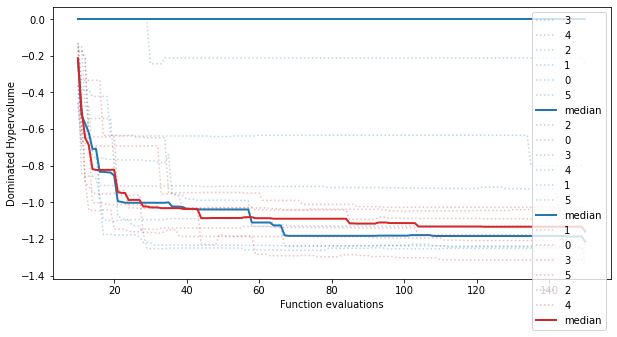

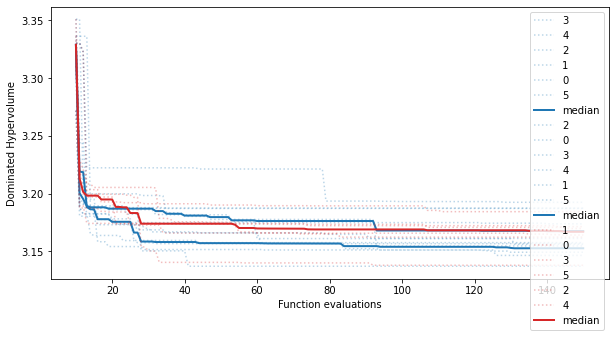

In [20]:
problem_name = test_functions[0]
print(problem_name)
fig0 = results_unattainable[problem_name][0].plot_hpv();
ax = fig0.gca()
results_unattainable[problem_name][1].plot_hpv(axis=ax, c="C0");
comp_results[problem_name].plot_hpv(axis=ax, c="C3");


fig1 = results_unattainable[problem_name][0].plot_igd();
ax = fig1.gca()
results_unattainable[problem_name][1].plot_igd(axis=ax, c="C0");
comp_results[problem_name].plot_igd(axis=ax, c="C3");

wfg4_2obj_6dim


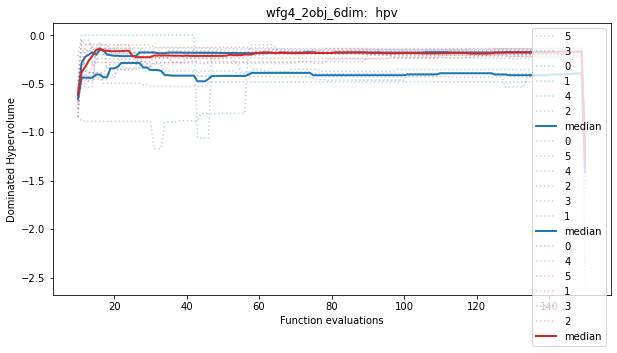

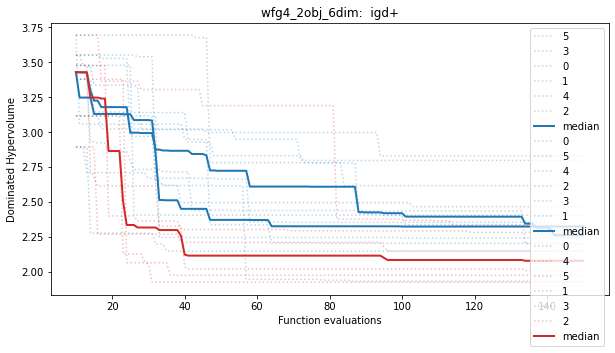

In [21]:
problem_name = test_functions[9]
print(problem_name)
fig0 = results_unattainable[problem_name][0].plot_hpv();
ax = fig0.gca()
ax.set_title(problem_name+":  hpv")
results_unattainable[problem_name][1].plot_hpv(axis=ax, c="C0");
comp_results[problem_name].plot_hpv(axis=ax, c="C3");


fig1 = results_unattainable[problem_name][0].plot_igd();
ax = fig1.gca()
ax.set_title(problem_name+":  igd+")
results_unattainable[problem_name][1].plot_igd(axis=ax, c="C0");
comp_results[problem_name].plot_igd(axis=ax, c="C3");

wfg5_2obj_6dim
wfg5_2obj_6dim


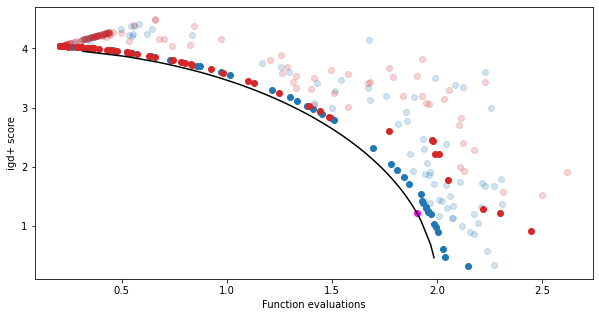

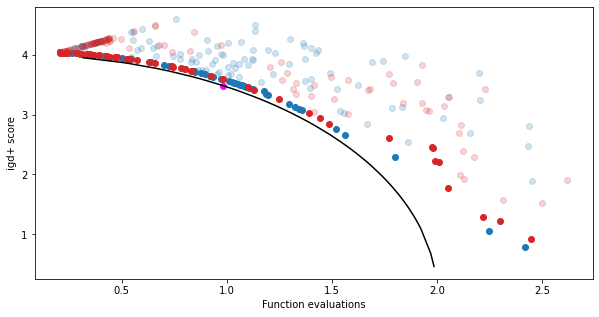

In [81]:
position = 0
iter_n = 5
problem_name = test_functions[12]

prob, obj, dim = strip_problem_names(problem_name)
true_func = getattr(wfg, f"WFG{prob}")
kf, lf = get_factors(obj, dim)
k = kf*(obj-1)   # position related params
l = lf*2    
x_samples = np.zeros((100, dim))
y_samples = np.zeros((100, obj))
for i in range(100):
    xi = wfg.random_soln(k, l, true_func.__name__)
    x_samples[i] = xi
    y_samples[i] = true_func(xi, k, obj) 
print(problem_name)
    

fig0 = results_pareto[problem_name][position][iter_n].plot_front();
ax = fig0.gca()
fig0 = comp_results[problem_name][iter_n].plot_front(axis=ax, c="C3");
ax.scatter(*results_pareto[problem_name][position][iter_n].targets.T, c="magenta")
ax.plot(*y_samples[np.argsort(y_samples[:,0])].T, c="k")

position = 1
print(problem_name)
fig1 = results_pareto[problem_name][position][iter_n].plot_front();
ax = fig1.gca()
fig1 = comp_results[problem_name][iter_n].plot_front(axis=ax, c="C3");
ax.scatter(*results_pareto[problem_name][position][iter_n].targets.T, c="magenta")
ax.plot(*y_samples[np.argsort(y_samples[:,0])].T, c="k")

In [6]:
x = np.random.uniform(0.5, 1.5, size=(20, 2))
t = np.array([[0.5, 0.5]])

In [7]:
from pymoo.factory import get_performance_indicator
from testsuite.utilities import single_target_dominated_hypervolume, Pareto_split


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False



-0.09560533924858135

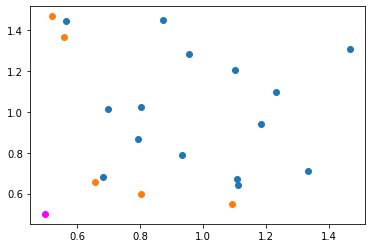

In [8]:
p, d = Pareto_split(x)
fig = plt.figure()
ax = fig.gca()
ax.scatter(*d.T, c="C0")
ax.scatter(*p.T, c="C1")
ax.scatter(*t.T, c="magenta")
single_target_dominated_hypervolume(p, t)

0.9912896159598428

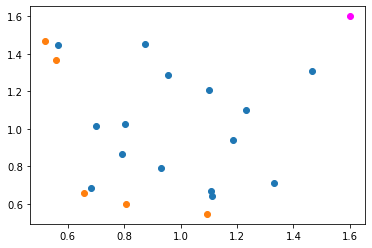

In [9]:
t2 = np.ones(2)*1.6

fig = plt.figure()
ax = fig.gca()
ax.scatter(*d.T, c="C0")
ax.scatter(*p.T, c="C1")
ax.scatter(*t2.T, c="magenta")
single_target_dominated_hypervolume(p, t2)